In [65]:
import numpy as np
import torch
from autora.theorist.bms import BMSRegressor
from gplearn.functions import make_function
from gplearn.genetic import SymbolicRegressor
from kan import KAN as PyKAN, create_dataset
from matplotlib import font_manager
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


# Comparison of Symbolic Regression using Kolmogorov-Arnold Networks (KANs), Genetic Programming methods and Bayes-based methods

In this notebook, we will compare three **symbolic regression** techniques for learning this **multivariate** mathematical function:

$$
y = sin(x_1^2) + e^{x_2} + 1
$$

1. **Kolmogorov-Arnold-Networks (KAN)**: We will train a KAN using the official **PyKAN** library, to perform symbolic regression.

2. **Genetic Programming**: We will use the **gplearn** library, which implements genetic programming, to find a symbolic representation of the function using evolutionary techniques.
   
3. **Bayesian Symbolic Regression (BSR)**: We will use the [autora](https://pypi.org/project/autora/) library to solve the symbolic regression task using the Bayesian approach.


## Dataset definition and plotting

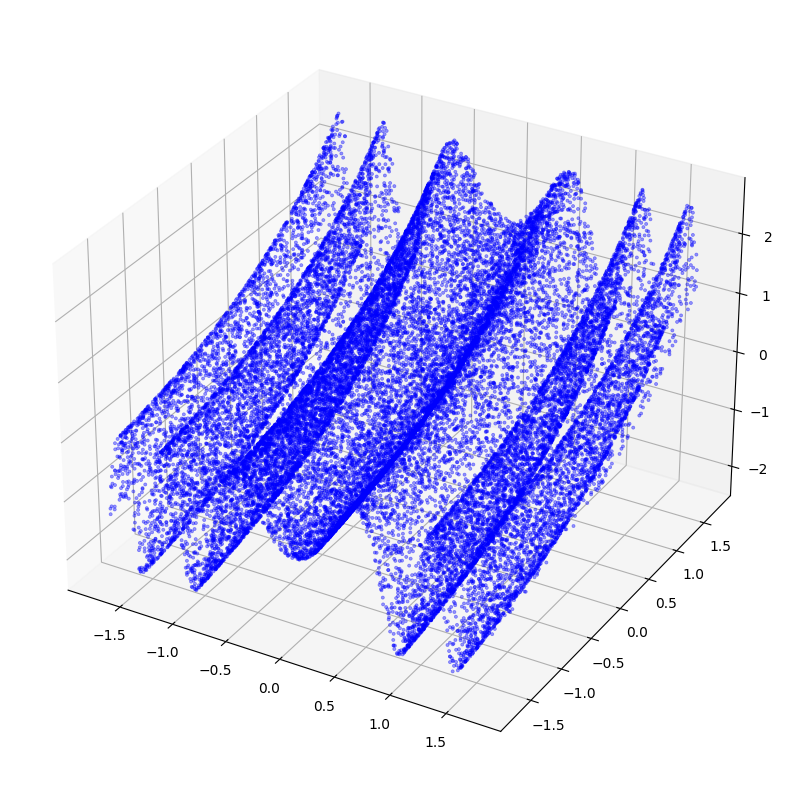

In [51]:
sin_exp = lambda x: torch.sin(x[:, 0] ** 2) + torch.exp(x[:, 1] / 4) + 1
noise_std = .05
dataset = create_dataset(sin_exp, n_var=2, ranges=[-4, 4], train_num=30000, test_num=5000,
                         normalize_input=True, normalize_label=True)
# dataset['train_label'] += np.random.normal(0, noise_std, (1000, ))
Xs, Ys = dataset['train_input'], dataset['train_label']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs[:, 0], Xs[:, 1], Ys, c='blue', marker='.', alpha=0.4, linewidths=.5)
plt.show()

## 1. Using a KAN

In [5]:
kan_model = PyKAN(width=[2, 2, 1], grid=4, k=3)
pass

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.00e-02 | test_loss: 1.98e-02 | reg: 1.33e+01 | : 100%|█| 100/100 [02:17<00:00,  1.37


saving model version 0.1


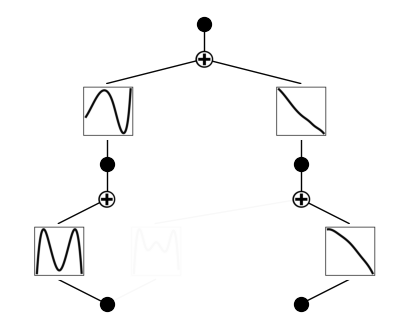

In [6]:
kan_model.fit(dataset, opt='LBFGS', steps=100, lamb=0.001, lamb_entropy=4)
kan_model.plot()

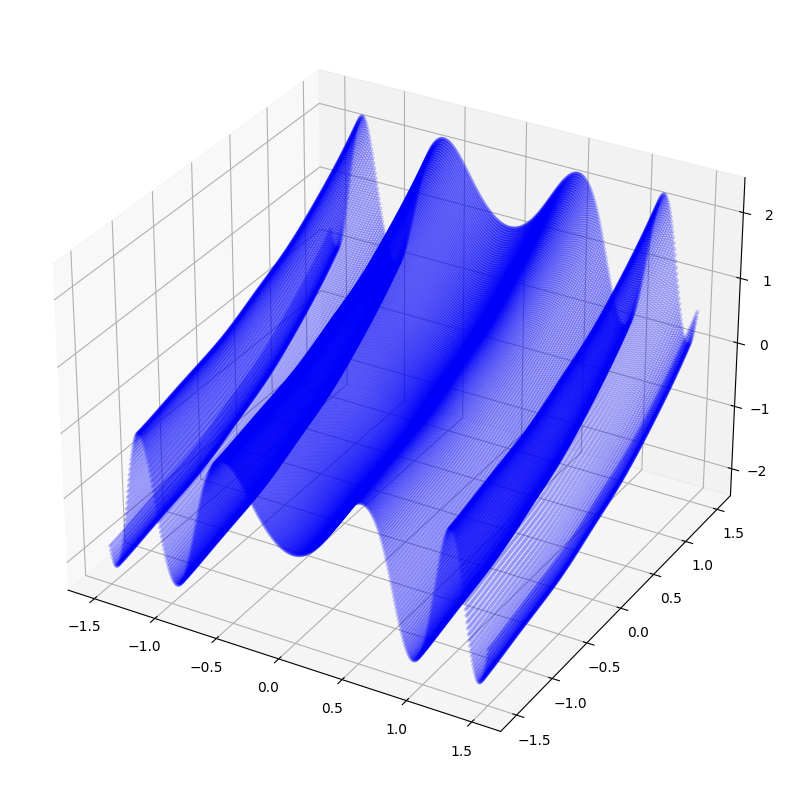

In [7]:
Xs2 = torch.cartesian_prod(torch.linspace(-1.5, 1.5, 500), torch.linspace(-1.5, 1.5, 200))
with torch.no_grad():
    Ys2 = kan_model(Xs2)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs2[:, 0], Xs2[:, 1], Ys2, c='blue', marker='.', alpha=0.15, linewidths=0.75)
plt.show()

## 2. Using a Gplearn

In [3]:
def _exponent(x):
    with np.errstate(divide='ignore', invalid='ignore'):
        a = np.exp(x)
        a[np.greater(a, 10)] = 10
        a[np.less(a, 1 / 10.)] = 1 / 10.
        return a


exp = make_function(function=_exponent, name='exp', arity=1)
genetic_model = SymbolicRegressor(
    population_size=30000,
    generations=12,
    init_depth=(4, 10),
    metric='mse',
    function_set=('add', 'mul', 'sin', exp),
    n_jobs=-1,
    verbose=1,
)

In [4]:
genetic_model.fit(Xs, Ys)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    47.50      1.93078e+16        4         0.519763              N/A      4.60m
   1    19.02          62.6914       27         0.500693              N/A      3.63m
   2     4.29          1.05118       26         0.491365              N/A      3.12m
   3     4.01           2.2432       25          0.47477              N/A      3.90m
   4     3.76          145.267       25          0.47477              N/A      4.15m
   5     5.10          0.90284       23         0.459325              N/A      3.38m
   6    10.03          1.06837       23         0.459325              N/A      2.35m
   7    13.25           1.4871       25         0.450412              N/A      2.76m
   8    14.16          0.84002       23         0.427481              N/A  

SymbolicRegressor(function_set=('add', 'mul', 'sin',
                                <gplearn.functions._Function object at 0x0000014E8520B820>),
                  generations=12, init_depth=(4, 10), metric='mse', n_jobs=-1,
                  population_size=30000, verbose=1)

## 3. Using BMS Regressor

In [13]:
bms_model = BMSRegressor(
    epochs=5,
    ts=[1.0] + [1.03 ** k for k in range(1, 100)],
)

In [14]:
bms_model.fit(Xs, Ys)

INFO:autora.theorist.bms.regressor:BMS fitting started
100%|██████████| 5/5 [00:26<00:00,  5.23s/it]
INFO:autora.theorist.bms.regressor:BMS fitting finished


X1

## Comparison of model results

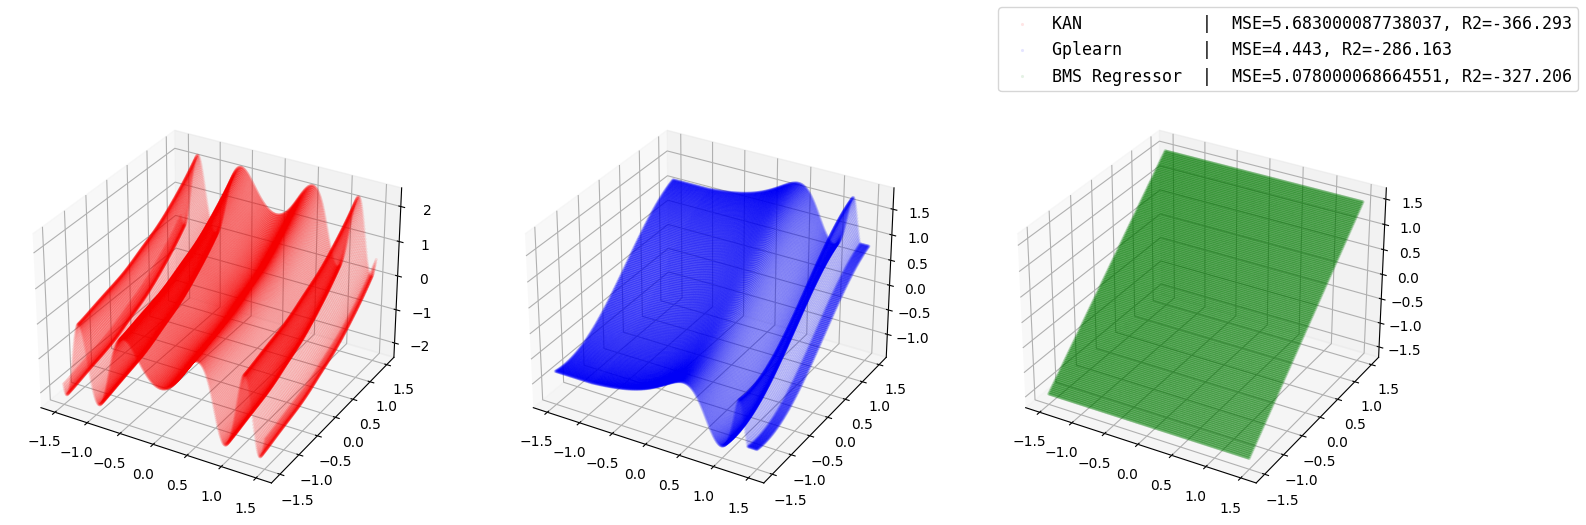

In [77]:
Xs2 = torch.cartesian_prod(torch.linspace(-1.5, 1.5, 500), torch.linspace(-1.5, 1.5, 150))
Ys2 = sin_exp(Xs2*1.5/4) # TODO
with torch.no_grad():
    kan_pred = kan_model(Xs2)
    genetic_pred = genetic_model.predict(Xs2)
    bms_pred = bms_model.predict(Xs2)

fig = plt.figure(figsize=(18, 6))
models = [('KAN', kan_pred, fig.add_subplot(131, projection='3d'), 'red'),
          ('Gplearn', genetic_pred, fig.add_subplot(132, projection='3d'), 'blue'),
          ('BMS Regressor', bms_pred, fig.add_subplot(133, projection='3d'), 'green')]
handles = []
for pred in models:
    mse, r2 = mean_squared_error(Ys2, pred[1]), r2_score(Ys2, pred[1])
    handles.append(pred[2].scatter(Xs2[:, 0], Xs2[:, 1], pred[1],
                                   label=f'{pred[0]}{" " * (max(map(lambda x: len(x[0]), models)) - len(pred[0]))}  |  MSE={round(mse, 3)}, R2={round(r2, 3)}',
                                   alpha=0.1, c=pred[3], marker='.', linewidths=0.01))
fig.legend(handles, map(lambda x: x.get_label(), handles),
           prop=font_manager.FontProperties(family='monospace', size=12))
# ax = fig.add_subplot(131, projection='3d')
# ax.scatter(Xs2[:, 0], Xs2[:, 1], Ys2, alpha=0.1, marker='.', linewidths=0.01)
plt.show()